Original at: https://github.com/sthorn/deep-learning-explorations/blob/master/predicting-uncertainty.ipynb


# Predicting uncertainty with (deep) neural networks

The idea is that a network that outputs a real-valued prediction can be (simply) modified to provide an estimate of the error on this prediction. Roughly speaking we do:

* Add an additional real-valued output to the network. The network now predicts two values: the output, $y$, and its error, $\sigma$

* Estimate the target value for the error, $\sigma$, from the difference between the target value of the output, $y$, and its predicted value, $\hat{y}$. We can use either: $\sigma^2 = (y-\hat{y})^2$ or $\sigma = \left| y-\hat{y}\right|$

* An easy way to do this at training time is with a customised loss function

### Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sklearn.metrics as m
from torch.autograd import Variable
import torch.nn.functional as F

%matplotlib inline

### Generate some random data

In [2]:
# Generate some linearly related data
n_samples = 10000
np.random.seed(4567)
x = np.random.random(n_samples)
eps = np.random.normal(scale=1.0, size=n_samples) * 0.4*np.sin(x*4*np.pi)
y = 2*x + 1 + eps

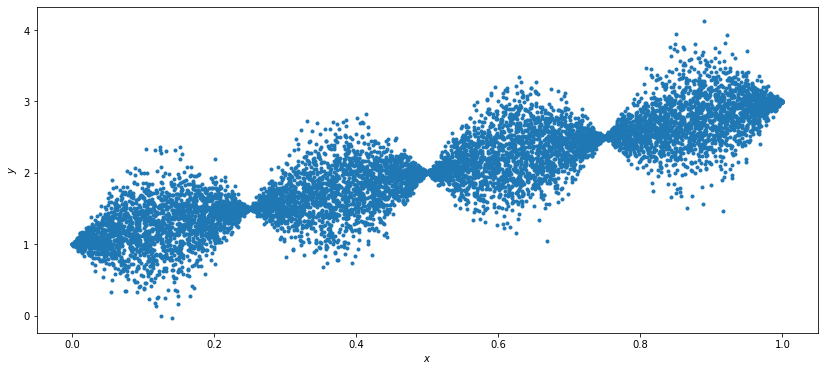

In [3]:
# Plot the data
plt.figure(figsize=(14,6))
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [4]:
# Add in column of dummy zeros to represent sigma 
#sigma = np.zeros(10000)
#y = np.stack([y, sigma], axis=1)
y = np.stack([y], axis=1)

In [5]:
# Reshape x for PyTorch
x = x.reshape(10000, 1)

In [6]:
# Split into training and validation sets
n_validation = 500
x_val, x = x[:n_validation], x[n_validation:]
y_val, y = y[:n_validation], y[n_validation:]

In [7]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.FloatTensor
x = Variable(torch.from_numpy(x).type(dtype))
y = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [8]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x.shape, y.shape

(torch.Size([9500, 1]), torch.Size([9500, 1]))

### Create a simple network 

In [9]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
##n_outputs = 2
n_outputs = 1
n_hidden = 1000
model = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           )

In [10]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Custom loss function
This is where the magic happens.

In [11]:
def custom_loss(input, target):
    
    # Estimate target value for sigma with abs(y_pred - y)
    #
    #    actual y     is target[:,0]
    # predicted y     is input[:,0]
    #    actual sigma is target[:,1]
    # predicted sigma is input[:,1]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    ##target[:,1] = Variable((input[:,0].data - target[:,0].data).abs(), requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

### Training loop 
We train this simple model with batch size equal to the whole dataset.

In [12]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model(x)
    
    # Calculate loss
    loss = custom_loss(y_pred, y)
    
    if i%500 == 0: print(f'epoch: {i:4}, loss: {loss.data:.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0, loss: 4.39
epoch:  500, loss: 0.0835
epoch: 1000, loss: 0.0833
epoch: 1500, loss: 0.0832
epoch: 2000, loss: 0.0832
epoch: 2500, loss: 0.0832
epoch: 3000, loss: 0.0832
epoch: 3500, loss: 0.0832
epoch: 4000, loss: 0.0832
epoch: 4500, loss: 0.0832
epoch: 5000, loss: 0.0832
epoch: 5500, loss: 0.0832
epoch: 6000, loss: 0.0832
epoch: 6500, loss: 0.0832
epoch: 7000, loss: 0.0831
epoch: 7500, loss: 0.0831
epoch: 8000, loss: 0.0831
epoch: 8500, loss: 0.0831
epoch: 9000, loss: 0.0831
epoch: 9500, loss: 0.0831


### Get predictions for validation set 

In [13]:
# Get predicted y and sigma for validation set
x_val_pytorch = Variable(torch.from_numpy(x_val).type(dtype)) 
pred = model(x_val_pytorch)
y_pred = pred[:,0].cpu().data
#sigma_pred = pred[:,1].cpu().data

tensor([[3.6197e-01],
        [9.8443e-01],
        [8.6920e-01],
        [6.9638e-01],
        [7.0749e-01],
        [9.8305e-01],
        [2.5925e-01],
        [1.3837e-01],
        [2.8614e-01],
        [2.6426e-01],
        [8.2797e-01],
        [4.5302e-01],
        [6.8019e-01],
        [9.1252e-01],
        [1.5013e-01],
        [6.3799e-02],
        [1.2847e-01],
        [8.8212e-02],
        [7.9935e-01],
        [3.1926e-01],
        [2.4233e-01],
        [7.9946e-01],
        [6.0682e-01],
        [8.8940e-01],
        [1.5741e-01],
        [1.2073e-01],
        [2.0883e-01],
        [2.4408e-01],
        [5.9225e-01],
        [8.8437e-01],
        [8.2493e-01],
        [3.4871e-01],
        [2.6009e-01],
        [5.7459e-01],
        [3.8184e-01],
        [9.1289e-01],
        [9.3400e-01],
        [6.0432e-01],
        [7.5045e-01],
        [4.0792e-01],
        [4.6030e-03],
        [9.6669e-01],
        [2.5591e-01],
        [2.4840e-01],
        [1.7864e-01],
        [6

### Plot results

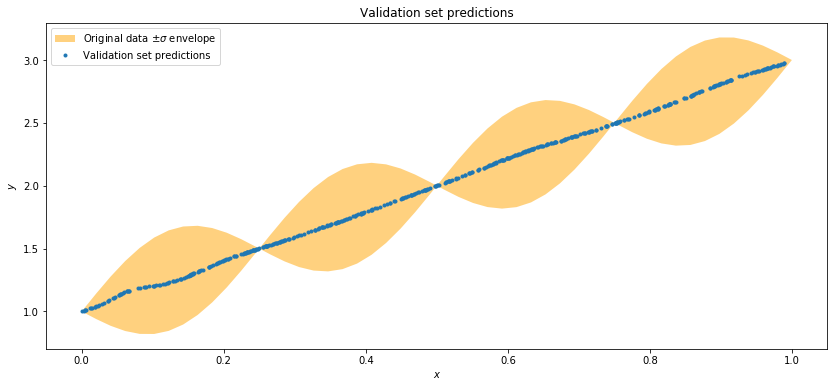

In [15]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
#plt.errorbar(x_val, y_pred, yerr=sigma_pred, fmt='.');
plt.errorbar(x_val, y_pred, fmt='.');
# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );

The following metric is to be compared with another notebook where variance is also trained in order to compare loss of precision.

In [18]:
m.r2_score(y_val,y_pred)

0.8008319692729339

For the record, the score training with variance is 0.8009559643409793 and training without variance is 0.8008319692729339.